## RLlib continued

In [1]:
# HIDDEN
import gym
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

In [2]:
# HIDDEN
import ray
import logging
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.ERROR); # logging.FATAL

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
# HIDDEN
from ray.rllib.algorithms.ppo import PPO, PPOConfig

#### RLlib features

- So far we've seen training, evaluation, and "prediction" with RLlib.
- Next we'll explore a few more features:
   - Algorithm configs
   - Saving/restoring models
   - Interpreting stochastic policies

#### Algorithm configs

Remember this code?

```python
from ray.rllib.algorithms.ppo import PPO, PPOConfig
ppo = PPO(env="FrozenLake-v1", config=ppo_config)
```

Previously, we hid the `ppo_config`. Now we'll delve into it.

In [4]:
ppo_config = PPOConfig()

In [2]:
# HIDDEN - this shows up in module 5 instead
# The number of options is way too many to read:
# len(ppo_config.to_dict())
# # ppo_config.to_dict()

#### Algorithm configs

- When we instantiate a `PPOConfig()` we get the default config values.
- There are a few values that we changed:

In [7]:
ppo_config = ppo_config.framework("torch")

⬆️ Changes the framework from tensorflow (default) to pytorch for the policy model.

In [8]:
ppo_config = ppo_config.debugging(seed=0, log_level="ERROR")

⬆️ Sets a random seed for reproducibility of the course, reduces the warnings displayed.

In [9]:
ppo_config = ppo_config.training(model={"fcnet_hiddens" : [32, 32]})

⬆️ Sets the policy neural network to have a smaller-than-default architecture, which helps the course materials run faster.

In [10]:
ppo_config = ppo_config.rollouts(create_env_on_local_worker=True)

⬆️ This relates to Ray, which we will touch on briefly in Module 5, but skip for now.

In [11]:
ppo_config = ppo_config.environment(env_config={"is_slippery" : False})

⬆️ This is how we set env parameters, in this case specifying the non-slippery Frozen Lake.

Notes:

Remember, the policy is a function from observations to actions, and this function is a neural network. That is why we need a deep learning framework like pytorch.

The random seed is only for the algorithm itself, e.g. randomness in the neural network optimization. It doesn't set the random seed for the environment's own randomness. 

#### Algorithm configs

We can also generate this config in one giant line of Python as follows:

In [12]:
ppo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [32, 32]})\
    .environment(env_config={"is_slippery" : False})
)

(The `\` character just means the line of Python continues below.)

Notes:

We'll discuss tuning in Module 5.

In [13]:
# HIDDEN
algo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [32, 32]})\
    .environment(env_config={"is_slippery" : False})
)

#### Building an algorithm from the config

We previously instantiated our PPO algorithm like this:

In [14]:
ppo = PPO(env="FrozenLake-v1", config=ppo_config)

The preferred syntax in the latest release of Ray/RLlib is:

In [15]:
ppo = ppo_config.build(env="FrozenLake-v1")

As a third option, you can also specify the environment in the config rather than as an argument to `build`:

In [16]:
ppo_config.environment(env="FrozenLake-v1")

ppo = ppo_config.build()

The end result is the same whichever way you choose.

#### Saving models

- We may want to save trained agents for future use.
- This is also called _checkpointing_, especially when done during a training loop.
- In RLlib, this can be done simply with:

```python
algo.save(path_to_checkpoint)
```

It can then be later restored with

```python
algo.restore(path_to_checkpoint)
```

Just make sure you create the trainer with the same environment and parameters when restoring from a checkpoint.

In [19]:
# # HIDDEN
# for i in range(30):
#     ppo.train()
# 
# ppo.save("models/FrozenLakeSlippery-256-Ray2");

#### Restoring models

- Let's restore a PPO algorithm object
- We need to set it up with the same config first:

In [ ]:
ppo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [64,64]})
    .environment(env_config={"is_slippery" : True})\
    .evaluation(evaluation_config = {"explore" : False})
)

ppo = ppo_config.build("FrozenLake-v1")

In [ ]:
ppo.restore("models/FrozenLakeSlippery-256-Ray2/checkpoint-50")

Notes:

Apparently, it was trained for 30 iterations, 124k time steps, 1 minute, 17k episodes.

#### Viewing stochastic policies

- If we want to see what a policy does, we can use `compute_single action`
- But, some RL algorithms, including PPO, learn _stochastic policies_.
- We may wish to look at these _action probabilities_.
- The code can be viewed on GitHub, but is hidden here:

In [50]:
import utils

In [51]:
env = gym.make("FrozenLake-v1")

We'll use the trainer we just restored:

In [63]:
probs = utils.query_policy(ppo, env, obs=0)
probs

array([3.0708601e-04, 8.6194783e-01, 1.3743131e-01, 3.1362689e-04],
      dtype=float32)

Actions: left (0), down (1), right (2), up (3).

#### Viewing stochastic policies

In [76]:
print(f"Left:  {probs[0]*100:5.2f}%")
print(f"Down:  {probs[1]*100:5.2f}%")
print(f"Right: {probs[2]*100:5.2f}%")
print(f"Up:    {probs[3]*100:5.2f}%")

Left:   0.03%
Down:  86.19%
Right: 13.74%
Up:     0.03%


Arena:

```
SFFF
FHFH
FFFH
HFFG
```

Notes:
    
What we see here are the action probabilities. From the top-left, the agent considers moving left down or right, but not up. Presumably left is preferred to up because slipping down is preferred to slipping right.

For a continuous action space this would be different.

#### Viewing stochastic policies

Let's view all the probabilities:

In [53]:
# HIDDEN
import pandas as pd

In [54]:
action_probs = {obs : query_policy(ppo, env, obs) for obs in range(16)}
pd.DataFrame(action_probs, index=["left", "down", "right", "up"]).T

,left,down,right,up
0,0.000307,0.861948,0.137431,0.000314
1,0.001545,0.000129,0.997325,0.001000
2,0.000614,0.997883,0.000648,0.000855
3,0.021768,0.002684,0.961310,0.014238
4,0.000100,0.999648,0.000107,0.000145
5,0.008260,0.198169,0.786407,0.007165
6,0.000059,0.999218,0.000640,0.000084
7,0.041046,0.286452,0.634076,0.038426
8,0.000334,0.000075,0.999394,0.000197
9,0.000094,0.029428,0.970416,0.000063


#### Viewing stochastic policies

We can also view this as an image:

In [59]:
# HIDDEN
# df = pd.DataFrame(action_probs, index=["left", "down", "right", "up"]).T
# plt.figure(figsize=(8,4))
# plt.imshow(df.values.T);
# plt.yticks(np.arange(4), labels=["left", "down", "up", "right"]);
# plt.xticks(np.arange(16), labels=np.arange(16));
# plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor");
# plt.xlabel("observations");
# plt.ylabel("actions");
# plt.colorbar(location="bottom");
# plt.tight_layout();

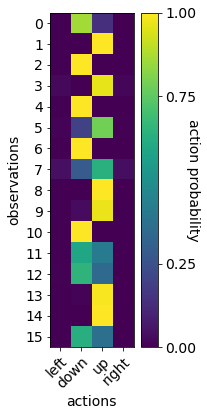

In [60]:
utils.plot_action_probs(action_probs)

Notes:
    
This is transposed to fit on the screen.

#### Acting stochastically

`compute_single_action` will act according to these probabilities:

In [61]:
action_probs[0]

array([3.0708601e-04, 8.6194783e-01, 1.3743131e-01, 3.1362689e-04],
      dtype=float32)

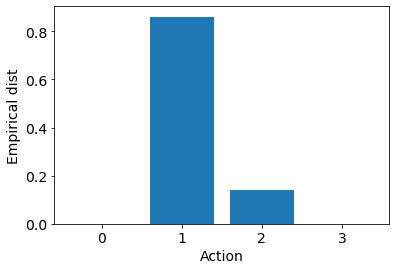

In [62]:
counts = np.bincount([ppo.compute_single_action(0) for _ in range(10_000)])
plt.bar([0,1,2,3], counts/10_000)
plt.xticks([0,1,2,3]);
plt.xlabel("Action");
plt.ylabel("Empirical dist");

#### Acting deterministically

We can also tell the agent to act deterministically with `explore=False`:

In [77]:
ppo.compute_single_action(0, explore=False)

1

In [78]:
print([ppo.compute_single_action(0, explore=False) for _ in range(100)])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Often this is desirable, but **sometimes the optimal policy is stochastic**.

Notes:

During training, exploration is a fundamental concept in RL. We will discuss it in Module 4!

In Module 4 we'll also see an example where the optimal policy is stochastic, so we would definitely not want to set `explore=False` in deployment.

#### Let's apply what we learned!

## RLlib config syntax
<!-- multiple choice -->

Which of the following is **NOT** correct RLlib syntax for instantiating a PPO algorithm instance? Assume the following import has already been run:

```python
from ray.rllib.algorithms.ppo import PPO, PPOConfig
```

- [ ] PPOConfig().build(env="FrozenLake-v1")
- [ ] PPOConfig().environment(env="FrozenLake-v1").build()
- [x] PPOConfig(env="FrozenLake-v1").build()
- [ ] PPO(env="FrozenLake-v1")

In [ ]:
# # HIDDEN
# from ray.rllib.algorithms.ppo import PPO, PPOConfig

# PPOConfig().framework("torch").build(env="FrozenLake-v1")
# PPOConfig().framework("torch").environment(env="FrozenLake-v1").build()
# PPO(env="FrozenLake-v1", config={"framework" : "torch"})
# PPOConfig(env="FrozenLake-v1").framework("torch").build()

## Saving/restoring models
<!-- multiple choice -->

Which of the following is **NOT** a plausible use of saving ("checkpointing") models in RLlib?

- [x] Checkpointing generates cryptocurrency.
- [ ] In a course like this, loading a checkpoint means you don't always have to wait for models to train.
- [ ] Saved models can be stored, shared, copied and/or moved for deployment.
- [ ] Training can be resumed from a checkpoint in case it fails and needs to be restarted.

In [ ]:
# TODO
# now that we have the fancier plotting code from module 5 (DQN), we could use it here also

## Cartpole environment
<!-- coding exercise -->

A famous benchmark environment in RL is the _Cartpole_ environment, in which the agent must balance an [inverted pendulum](https://en.wikipedia.org/wiki/Inverted_pendulum) by applying force on the cart (at the bottom) to keep it stable. More information is available in the gym documentation [here](https://www.gymlibrary.ml/environments/classic_control/cart_pole/).

Note: the code below imports the env `MyCartPole`. This is identical to gym's `'CartPole-v1'` except that the rendering method has been overridden with something that can be displayed inside of this interactive course platform. 

In [79]:
# SOLUTION
import numpy as np
import time
from IPython import display

from envs import MyCartPole
from ray.rllib.algorithms.ppo import PPO, PPOConfig

config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [32,32]})
)

ppo = config.build(env=MyCartPole);

In [ ]:
rewards = []
for i in range(50):
    out = ppo.train()
    rewards.append(out["episode_reward_mean"])

In [ ]:
env = MyCartPole()
obs = env.reset()

for i in range(20):
    
    action = ppo.compute_single_action(obs)
    
    obs, reward, done, _ = env.step(action)

    env.render()
    time.sleep(0.2)

display.clear_output(wait=True);

# make a plot of prob(push left) vs. angle??

# TODO

need to be able to load a trained model here, which is currently not working. then, split this up into 2 coding exercises, one with the video and one with the plot.

In [ ]:
from utils import query_policy
import numpy as np
import matplotlib.pyplot as plt

angle_range_deg = np.arange(-15,15,0.1)
push_left_probs = 0*angle_range_deg

for i, angle_deg in enumerate(angle_range_deg):
    angle_rad = angle_deg/180*np.pi
    
    obs = np.zeros(4)
    obs[2] = angle_rad

    push_left_probs[i] = query_policy(ppo, env, obs, actions=[0,1])[0]

plt.plot(angle_range_deg, push_left_probs);
plt.xlabel("pole angle (degrees)")
plt.ylabel("probability of pushing left");

#### Interpreting the plot

How does the observed pole angle affect the trained agent's probability of pushing left?

- [ ] Positive pole angles (leaning right) result in the agent pushing the cart left. | The agent wants to push the cart underneath the top of the pole.
- [x] Negative pole angles (leaning left) result in the agent pushing the cart left.
- [ ] The agent's probability of pushing left is not significantly affected by the pole angle.
- [ ] None of the above.